In [104]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from astropy.constants import G as G_astropy
import astropy.units as u

import sys
from joblib import Parallel, delayed

from matplotlib import rc
import matplotlib as mpl
import math
import os

In [124]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
'#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

nbootstrap = 1000
np.random.seed(162)

rcut = 0.5
zcut = 1.0
nspoke = 50

Rsolar = 8.2
Rmin = 7.2
Rmax = 9.2
dR = 0.1

pgf_with_rc_fonts = {"pgf.texsystem": "pdflatex"}
mpl.rcParams.update(pgf_with_rc_fonts)

In [106]:
class snapshot_header:
    def __init__(self, filename):
        if (not os.path.exists(filename)):
            print("file not found:", filename)
            sys.exit()
      
        self.filename = filename  
        f = open(filename,'rb')    
        blocksize = np.fromfile(f,dtype=np.int32,count=1)
        if blocksize[0] == 8:
            swap = 0
            format = 2
        elif blocksize[0] == 256:
            swap = 0
            format = 1  
        else:
            blocksize.byteswap(True)
            if blocksize[0] == 8:
                swap = 1
                format = 2
            elif blocksize[0] == 256:
                swap = 1
                format = 1
            else:
                print("incorrect file format encountered when reading header of", filename)
                sys.exit()
    
        self.format = format
        self.swap = swap
    
        if format==2:
            f.seek(16, os.SEEK_CUR)
    
        self.npart = np.fromfile(f,dtype=np.int32,count=6)
        self.massarr = np.fromfile(f,dtype=np.float64,count=6)
        self.time = (np.fromfile(f,dtype=np.float64,count=1))[0]
        self.redshift = (np.fromfile(f,dtype=np.float64,count=1))[0]
        self.sfr = (np.fromfile(f,dtype=np.int32,count=1))[0]
        self.feedback = (np.fromfile(f,dtype=np.int32,count=1))[0]
        self.nall = np.fromfile(f,dtype=np.int32,count=6)
        self.cooling = (np.fromfile(f,dtype=np.int32,count=1))[0]
        self.filenum = (np.fromfile(f,dtype=np.int32,count=1))[0]
        self.boxsize = (np.fromfile(f,dtype=np.float64,count=1))[0]
        self.omega_m = (np.fromfile(f,dtype=np.float64,count=1))[0]
        self.omega_l = (np.fromfile(f,dtype=np.float64,count=1))[0]
        self.hubble = (np.fromfile(f,dtype=np.float64,count=1))[0]
    
        if swap:
            self.npart.byteswap(True)
            self.massarr.byteswap(True)
            self.time = self.time.byteswap()
            self.redshift = self.redshift.byteswap()
            self.sfr = self.sfr.byteswap()
            self.feedback = self.feedback.byteswap()
            self.nall.byteswap(True)
            self.cooling = self.cooling.byteswap()
            self.filenum = self.filenum.byteswap()
            self.boxsize = self.boxsize.byteswap()
            self.omega_m = self.omega_m.byteswap()
            self.omega_l = self.omega_l.byteswap()
            self.hubble = self.hubble.byteswap()
     
        f.close()
 


#----- find offset and size of data block ----- 

def find_block(filename, format, swap, block, block_num, only_list_blocks=False):
    if (not os.path.exists(filename)):
        print("file not found:", filename)
        sys.exit()
            
    f = open(filename,'rb')
    f.seek(0, os.SEEK_END)
    filesize = f.tell()
    f.seek(0, os.SEEK_SET)
  
    found = False
    curblock_num = 1
    while ((not found) and (f.tell()<filesize)):
        if format==2:
            f.seek(4, os.SEEK_CUR)
            curblock = f.read(4)
            if (block == curblock):
                found = True
            f.seek(8, os.SEEK_CUR)  
        else:
            if curblock_num==block_num:
                found = True
        
        curblocksize = (np.fromfile(f,dtype=np.int32,count=1))[0]
        if swap:
            curblocksize = curblocksize.byteswap()
    
    # - print some debug info about found data blocks -
    #if format==2:
    #  print curblock, curblock_num, curblocksize
    #else:
    #  print curblock_num, curblocksize
    
        if only_list_blocks:
            print(curblock_num,curblock,f.tell(),curblocksize)
            found = False
    
        if found:
            blocksize = curblocksize
            offset = f.tell()
        else:
            f.seek(curblocksize, os.SEEK_CUR)
            blocksize_check = (np.fromfile(f,dtype=np.int32,count=1))[0]
            if swap: blocksize_check = blocksize_check.byteswap()
            if (curblocksize != blocksize_check):
                print("something wrong")
                sys.exit()
            curblock_num += 1
      
    f.close()
      
    if ((not found) and (not only_list_blocks)):
        print("Error: block not found")
        sys.exit()
    
    if (not only_list_blocks):
        return offset,blocksize
 
# ----- read data block -----
 
def read_block(filename, block, parttype=-1, physical_velocities=True, arepo=0, no_masses=False, verbose=False):
    if (verbose):
	    print("reading block", block)
  
    blockadd=0
    blocksub=0
  
    if arepo==0:
        if (verbose):	
	        print("Gadget format")
        blockadd=0
    if arepo==1:
        if (verbose):	
	        print("Arepo format")
        blockadd=1	
    if arepo==2:
        if (verbose):
	        print("Arepo extended format")
        blockadd=4	
    if no_masses==True:
        if (verbose):	
	        print("No mass block present")    
        blocksub=1
		 
    if parttype not in [-1,0,1,2,3,4,5]:
        print("wrong parttype given")
        sys.exit()
  
    if os.path.exists(filename):
        curfilename = filename
    elif os.path.exists(filename+".0"):
        curfilename = filename+".0"
    else:
        print("file not found:", filename)
        print("and:", curfilename)
        sys.exit()
  
    head = snapshot_header(curfilename)
    format = head.format
    swap = head.swap
    npart = head.npart
    massarr = head.massarr
    nall = head.nall
    filenum = head.filenum
    redshift = head.redshift
    time = head.time
    del head
  
  # - description of data blocks -
  # add or change blocks as needed for your Gadget version
    data_for_type = np.zeros(6,bool) # should be set to "True" below for the species for which data is stored in the data block
    dt = np.float32 # data type of the data in the block
    if block=="POS ":
        data_for_type[:] = True
        dt = np.dtype((np.float32,3))
        block_num = 2
    elif block=="VEL ":
        data_for_type[:] = True
        dt = np.dtype((np.float32,3))
        block_num = 3
    elif block=="ID  ":
        data_for_type[:] = True
        dt = np.uint32
        block_num = 4
    elif block=="MASS":
        data_for_type[np.where(massarr==0)] = True
        block_num = 5
        if parttype>=0 and massarr[parttype]>0:   
            if (verbose):	
	            print("filling masses according to massarr")   
            return np.ones(nall[parttype],dtype=dt)*massarr[parttype]
    elif block=="U   ":
        data_for_type[:] = True
        dt = np.dtype((np.float32))
        block_num = 6#-blocksub
    elif block=="RHO ":
        data_for_type[0] = True
        block_num = 7-blocksub
    elif block=="VOL ":
        data_for_type[0] = True
        block_num = 8-blocksub 
    elif block=="CMCE":
        data_for_type[0] = True
        dt = np.dtype((np.float32,3))
        block_num = 9-blocksub 
    elif block=="AREA":
        data_for_type[0] = True
        block_num = 10-blocksub
    elif block=="NFAC":
        data_for_type[0] = True
        dt = np.dtype(np.int32)	
        block_num = 11-blocksub
    elif block=="NE  ":
        data_for_type[0] = True
        block_num = 8+blockadd-blocksub
    elif block=="NH  ":
        data_for_type[0] = True
        block_num = 9+blockadd-blocksub
    elif block=="HSML":
        data_for_type[0] = True
        block_num = 10+blockadd-blocksub
    elif block=="SFR ":
        data_for_type[0] = True
        block_num = 11+blockadd-blocksub
    elif block=="AGE ":
        data_for_type[4] = True
        block_num = 12+blockadd-blocksub
    elif block=="Z   ":
        data_for_type[0] = True
        data_for_type[4] = True
        block_num = 13+blockadd-blocksub
    elif block=="BHMA":
        data_for_type[5] = True
        block_num = 14+blockadd-blocksub
    elif block=="BHMD":
        data_for_type[5] = True
        block_num = 15+blockadd-blocksub
    elif block=="COOR":
        data_for_type[0] = True
        block_num = -1 
    else:
        print("Sorry! Block type", block, "not known!")
        sys.exit()
  # - end of block description -

    if (block_num < 0 and format==1):
        print("Sorry! Block number of", block, "not known! Unable to read this block from format 1 file!")
        sys.exit() 
    
    actual_data_for_type = np.copy(data_for_type)  
    if parttype >= 0:
        actual_data_for_type[:] = False
        actual_data_for_type[parttype] = True
        if data_for_type[parttype]==False:
            print("Error: no data for specified particle type", parttype, "in the block", block)   
            sys.exit()
    elif block=="MASS":
        actual_data_for_type[:] = True  
    
    allpartnum = np.int64(0)
    species_offset = np.zeros(6,np.int64)
    for j in range(6):
        species_offset[j] = allpartnum
        if actual_data_for_type[j]:
            allpartnum += nall[j]
    filenum=1  
    for i in range(filenum): # main loop over files
        if filenum>1:
            curfilename = filename+"."+str(i)
      
        if i>0:
            head = snapshot_header(curfilename)
            npart = head.npart  
            del head
      
        curpartnum = np.int32(0)
        cur_species_offset = np.zeros(6,np.int64)
        for j in range(6):
            cur_species_offset[j] = curpartnum
            if data_for_type[j]:
                curpartnum += npart[j]
    
        if parttype>=0:
            actual_curpartnum = npart[parttype]      
            add_offset = cur_species_offset[parttype] 
        else:
            actual_curpartnum = curpartnum
            add_offset = np.int32(0)
      
        offset,blocksize = find_block(curfilename,format,swap,block,block_num)
    
        if i==0: # fix data type for ID if long IDs are used
            if block=="ID  ":
                if blocksize == np.dtype(dt).itemsize*curpartnum * 2:
                    dt = np.uint64 
        
        if np.dtype(dt).itemsize*curpartnum != blocksize:
            print("something wrong with blocksize! expected =",np.dtype(dt).itemsize*curpartnum,"actual =",blocksize)
            sys.exit()
    
        f = open(curfilename,'rb')
        f.seek(offset + add_offset*np.dtype(dt).itemsize, os.SEEK_CUR)  
        curdat = np.fromfile(f,dtype=dt,count=actual_curpartnum) # read data
        f.close()  
        if swap:
            curdat.byteswap(True)  
      
        if i==0:
            data = np.empty(allpartnum,dt)
    
        for j in range(6):
            if actual_data_for_type[j]:
                if block=="MASS" and massarr[j]>0: # add mass block for particles for which the mass is specified in the snapshot header
                    data[species_offset[j]:species_offset[j]+npart[j]] = massarr[j]
                else:
                    if parttype>=0:
                        data[species_offset[j]:species_offset[j]+npart[j]] = curdat
                    else:
                        data[species_offset[j]:species_offset[j]+npart[j]] = curdat[cur_species_offset[j]:cur_species_offset[j]+npart[j]]
                species_offset[j] += npart[j]

        del curdat

    if physical_velocities and block=="VEL " and redshift!=0:
        data *= math.sqrt(time)

    return data
  
# ----- list all data blocks in a format 2 snapshot file -----

def list_format2_blocks(filename):
    if (not os.path.exists(filename)):
        print("file not found:", filename)
        sys.exit()
  
    head = snapshot_header(filename)
    format = head.format
    swap = head.swap
    del head
  
    if (format != 2):
        print("not a format 2 snapshot file")
        sys.exit()
            
    print("#   BLOCK   OFFSET   SIZE")
    print("-------------------------")
  
    find_block(filename, format, swap, "XXXX", 0, only_list_blocks=True)
  
    print("-------------------------")

In [107]:
def gen_pos():
    theta = np.linspace(0, 2.*np.pi, nspoke)

    posx = Rsolar * np.cos(theta)
    posy = Rsolar * np.sin(theta)
    posz = np.zeros(len(posx))
    pos = np.transpose([posx, posy, posz])
    return theta, pos

In [108]:
t = [1,2,3,4,5]
print(t[2:])
print(t[3:])

[3, 4, 5]
[4, 5]


In [109]:
def get_init_keys(p, star_pos):
    pos_diff = np.subtract(star_pos, p)
    rmag = np.linalg.norm(pos_diff[:,:2], axis=1)
    rbool = rmag < rcut
    zbool = np.abs(pos_diff[:,2]) < 2.0 * zcut
    keys = np.where(np.logical_and(rbool, zbool))[0]
    return keys

In [110]:
def get_keys(p, part):
    pos_diff = np.subtract(part, p)
    rmag = np.linalg.norm(pos_diff[:,:2], axis=1)
    rbool = rmag < rcut
    zbool = np.abs(pos_diff[:,2]) < zcut
    keys = np.where(np.logical_and(rbool, zbool))[0]
    return keys

In [111]:
def _midplane_med_(pos, init_pos, init_vel):
    mid_pos = pos.copy()
    for _ in range(10):
        keys = get_keys(mid_pos, init_pos)
        mid_pos[2] = np.median(init_pos[:,2][keys])
    mid_vel = np.median(init_vel[:,2][keys])
    return mid_pos[2], mid_vel

In [112]:
def get_midplane_with_error(pos, star_pos, star_vel):
    midplane = _midplane_med_
    # get all particles within 2x zheight
    init_keys = get_init_keys(pos, star_pos)
    init_pos = star_pos[init_keys]
    init_vel = star_vel[init_keys]

    # calculate midplane using all particles
    midplane_central, midplane_vel = midplane(pos, init_pos, init_vel)
    
    # prepare to bootstrap
    
    keys_to_choose = list(range(len(init_pos)))
    rand_choice = np.random.choice(keys_to_choose, len(init_pos)*nbootstrap)
    rand_choice = np.reshape(rand_choice, (nbootstrap, len(init_pos)))
    init_pos_rand = init_pos[rand_choice]
    init_vel_rand = init_vel[rand_choice]
    med_rand = np.array([ midplane(pos, ipos, ivel) for ipos,ivel in zip(init_pos_rand,init_vel_rand) ])
    dist_pos = np.subtract(med_rand[:,0], midplane_central)
    dist_vel = np.subtract(med_rand[:,1], midplane_vel)
    up_pos = np.percentile(dist_pos, 95)
    low_pos = np.percentile(dist_pos, 5)
    up_vel = np.percentile(dist_vel, 95)
    low_vel = np.percentile(dist_vel, 5)
    l = midplane_central - up_pos
    h = midplane_central - low_pos
    l_v = midplane_vel - up_vel
    h_v = midplane_vel - low_vel
    return midplane_central, l, h, midplane_vel, l_v, h_v

In [113]:
def fit(x, theta):
    return x[0]*np.cos(theta+x[1]) + x[2]

def chisq(x, theta, midplane_est):
    return np.sum(np.square(np.subtract(fit(x, theta), midplane_est)))

In [119]:
from astropy.table import Table
def main(gal):
    
    snap = Table.read('/home/douglas/Chervin/PhaseSpace'+gal+'.fits',format = 'fits')
    
    star_pos = np.zeros((len(snap["X"]),3))
    star_pos[:,0] = snap["X"]
    star_pos[:,1] = snap["Y"]
    star_pos[:,2] = snap["Z"]
    star_vel = np.zeros((len(snap["U"]),3))
    star_vel[:,0] = snap["U"]
    star_vel[:,1] = snap["V"]
    star_vel[:,2] = snap["U"]
    
    
    Rsnap = np.sqrt(star_pos[:,0]**2 + star_pos[:,1]**2)
    Rchoose = Rsnap - Rsolar
    ichoose = np.where( (np.abs(Rchoose)<0.5) & (np.abs(star_pos[:,2])<10) & (star_pos[:,2] < 1) & (star_pos[:,2] > -1))
    star_pos = star_pos[ichoose]
    star_vel = star_vel[ichoose]
    
    
    theta, pos = gen_pos()

    result = Parallel(n_jobs=-1) (delayed(get_midplane_with_error)(p, star_pos, star_vel) for p in tqdm(pos))
    result = np.array(result)
    #for p in pos:
     #   result = get_midplane_with_error(p,star_pos,star_vel)
      #  result = np.array(result)

    midplane_est = result[:,0]

    res = minimize(chisq, np.array([0.1, 0, 0]), args=(theta, midplane_est), method='Nelder-Mead')
    A = res.x[0]
    B = res.x[1]
    C = res.x[2]
    print('A=', A, 'B=', B, 'C=', C)
    fit = A*np.cos(theta + B) + C

    out = np.concatenate((theta.reshape(nspoke, 1), result, fit.reshape(nspoke,1)), axis=1)
    np.save('/home/douglas/Chervin/out_'+gal+'.npy', out)


In [120]:
glist = ['Disk_200', 'Disk_400', 'Disk_600', 'Disk_690']
for gal in glist:
    main(gal)




  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]


 32%|███▏      | 16/50 [00:06<00:35,  1.06s/it]


 34%|███▍      | 17/50 [00:07<00:33,  1.03s/it]


 38%|███▊      | 19/50 [00:08<00:23,  1.34it/s]


 40%|████      | 20/50 [00:08<00:17,  1.75it/s]


 44%|████▍     | 22/50 [00:08<00:11,  2.37it/s]


 46%|████▌     | 23/50 [00:08<00:10,  2.49it/s]


 48%|████▊     | 24/50 [00:13<00:46,  1.78s/it]


 50%|█████     | 25/50 [00:14<00:36,  1.47s/it]


 52%|█████▏    | 26/50 [00:14<00:26,  1.12s/it]


 54%|█████▍    | 27/50 [00:15<00:19,  1.16it/s]


 58%|█████▊    | 29/50 [00:15<00:13,  1.58it/s]


 62%|██████▏   | 31/50 [00:15<00:09,  2.04it/s]


 64%|██████▍   | 32/50 [00:20<00:31,  1.74s/it]


 66%|██████▌   | 33/50 [00:20<00:22,  1.33s/it]


 68%|██████▊   | 34/50 [00:21<00:17,  1.07s/it]


 72%|███████▏  | 36/50 [00:21<00:10,  1.31it/s]


 74%|███████▍  | 37/50 [00:21<00:08,  1.60it/s]


 76%|███████▌  | 38/50 [00:21<00:06,  1.93it/s]


 78%|██

A= 0.009526580590596523 B= 0.001298461973377398 C= 0.002571824632067071





  0%|          | 0/50 [00:00<?, ?it/s]


 32%|███▏      | 16/50 [00:06<00:13,  2.52it/s]


 34%|███▍      | 17/50 [00:06<00:12,  2.70it/s]


 36%|███▌      | 18/50 [00:06<00:09,  3.32it/s]


 40%|████      | 20/50 [00:06<00:06,  4.32it/s]


 42%|████▏     | 21/50 [00:07<00:07,  4.11it/s]


 48%|████▊     | 24/50 [00:13<00:20,  1.27it/s]


 50%|█████     | 25/50 [00:13<00:17,  1.46it/s]


 54%|█████▍    | 27/50 [00:13<00:11,  1.98it/s]


 56%|█████▌    | 28/50 [00:14<00:08,  2.56it/s]


 58%|█████▊    | 29/50 [00:14<00:07,  2.93it/s]


 60%|██████    | 30/50 [00:14<00:06,  3.23it/s]


 62%|██████▏   | 31/50 [00:14<00:05,  3.51it/s]


 64%|██████▍   | 32/50 [00:20<00:32,  1.81s/it]


 66%|██████▌   | 33/50 [00:20<00:24,  1.43s/it]


 70%|███████   | 35/50 [00:20<00:15,  1.02s/it]


 72%|███████▏  | 36/50 [00:21<00:11,  1.26it/s]


 74%|███████▍  | 37/50 [00:21<00:07,  1.67it/s]


 76%|███████▌  | 38/50 [00:21<00:06,  1.90it/s]


 78%|███████▊  | 39/50 [00:21<00:04,  2.44it/s]


 80%|█

A= 0.0024763741341827764 B= 0.00067572753301701 C= -0.007796847335283278





  0%|          | 0/50 [00:00<?, ?it/s]


 32%|███▏      | 16/50 [00:05<00:11,  3.06it/s]


 34%|███▍      | 17/50 [00:05<00:12,  2.72it/s]


 38%|███▊      | 19/50 [00:05<00:08,  3.51it/s]


 42%|████▏     | 21/50 [00:06<00:06,  4.55it/s]


 46%|████▌     | 23/50 [00:06<00:04,  5.71it/s]


 48%|████▊     | 24/50 [00:11<00:41,  1.61s/it]


 50%|█████     | 25/50 [00:11<00:30,  1.21s/it]


 54%|█████▍    | 27/50 [00:11<00:19,  1.16it/s]


 58%|█████▊    | 29/50 [00:11<00:13,  1.61it/s]


 62%|██████▏   | 31/50 [00:12<00:10,  1.80it/s]


 64%|██████▍   | 32/50 [00:16<00:31,  1.76s/it]


 66%|██████▌   | 33/50 [00:17<00:23,  1.36s/it]


 68%|██████▊   | 34/50 [00:17<00:16,  1.03s/it]


 70%|███████   | 35/50 [00:17<00:11,  1.33it/s]


 72%|███████▏  | 36/50 [00:18<00:09,  1.54it/s]


 74%|███████▍  | 37/50 [00:19<00:09,  1.31it/s]


 76%|███████▌  | 38/50 [00:20<00:11,  1.06it/s]


 78%|███████▊  | 39/50 [00:22<00:13,  1.25s/it]


 80%|████████  | 40/50 [00:27<00:23,  2.32s/it]


 84%|█

A= -0.21210832930650303 B= -0.6318714740591402 C= -0.06448101126032707





  0%|          | 0/50 [00:00<?, ?it/s]


 32%|███▏      | 16/50 [00:03<00:07,  4.53it/s]


 38%|███▊      | 19/50 [00:03<00:05,  5.33it/s]


 42%|████▏     | 21/50 [00:04<00:05,  5.36it/s]


 46%|████▌     | 23/50 [00:04<00:04,  6.41it/s]


 48%|████▊     | 24/50 [00:07<00:23,  1.09it/s]


 50%|█████     | 25/50 [00:07<00:19,  1.31it/s]


 52%|█████▏    | 26/50 [00:07<00:15,  1.55it/s]


 54%|█████▍    | 27/50 [00:08<00:16,  1.43it/s]


 56%|█████▌    | 28/50 [00:10<00:22,  1.03s/it]


 58%|█████▊    | 29/50 [00:13<00:35,  1.70s/it]


 60%|██████    | 30/50 [00:14<00:27,  1.36s/it]


 62%|██████▏   | 31/50 [00:14<00:18,  1.00it/s]


 64%|██████▍   | 32/50 [00:14<00:13,  1.36it/s]


 66%|██████▌   | 33/50 [00:14<00:10,  1.62it/s]


 68%|██████▊   | 34/50 [00:15<00:08,  1.84it/s]


 70%|███████   | 35/50 [00:15<00:07,  1.92it/s]


 72%|███████▏  | 36/50 [00:16<00:08,  1.65it/s]


 74%|███████▍  | 37/50 [00:18<00:11,  1.10it/s]


 78%|███████▊  | 39/50 [00:18<00:07,  1.50it/s]


 82%|█

A= -0.3938806998126452 B= -0.9988374229300339 C= -0.05311898752372655


In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from matplotlib import rc
import matplotlib as mpl

tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
'#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

nbootstrap = 1000
np.random.seed(162)

rcut = 0.5
zcut = 1.0
nspoke = 50

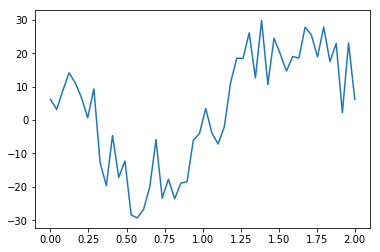

In [2]:
out = np.load('/home/douglas/Chervin/out_Disk_200.npy')
theta = np.array(out[:,0])
result = np.array(out[:,1:7])
fit = np.array(out[:,7])

midplane_est = np.array(result[:,0])
err_low = np.array(result[:,1])
err_high = np.array(result[:,2])

midplane_vel = np.array(result[:,3])
err_vel_low = np.array(result[:,4])
err_vel_high = np.array(result[:,5])
import matplotlib.pyplot as plt
plt.plot(theta/np.pi, midplane_est*1000)

Disk_200 0.049099676809808056
Disk_400 0.06190261923264151
Disk_600 0.13676731653328528
Disk_690 0.11870482902762125


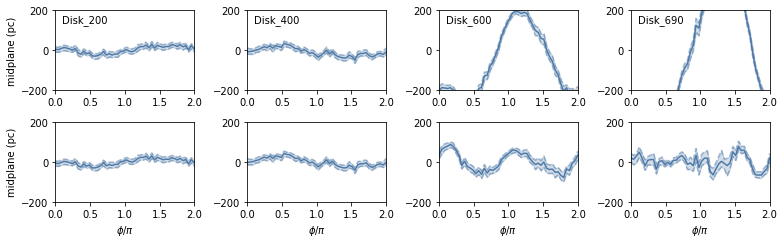

In [4]:
glist = ['Disk_200', 'Disk_400', 'Disk_600', 'Disk_690']
column = [0,1,2,3]
fig,axs = plt.subplots(2,4,figsize=(11,3.5))
for gal,col in zip(glist,column):
    out = np.load('/home/douglas/Chervin/out_'+gal+'.npy')
    theta = out[:,0]
    result = out[:,1:7]
    fit = out[:,7]

    midplane_est = result[:,0]
    err_low = result[:,1]
    err_high = result[:,2]

    midplane_vel = result[:,3]
    err_vel_low = result[:,4]
    err_vel_high = result[:,5]
    
    axs[0,col].plot(theta/np.pi, midplane_est*1000, c=tb_c[0])
    axs[0,col].plot(theta/np.pi, err_low*1000, c=tb_c[0], ls='dashed', alpha=0.5)
    axs[0,col].plot(theta/np.pi, err_high*1000, c=tb_c[0], ls='dashed', alpha=0.5)
    axs[0,col].fill_between(theta/np.pi, err_high*1000, err_low*1000, color=tb_c[0], alpha=0.25)
    
    axs[1,col].set_xlabel('$\phi/\pi$')

    axs[0,col].text(0.05, 0.88, gal, horizontalalignment='left', verticalalignment='center', transform = axs[0,col].transAxes)

    axs[0,col].set_xlim(0, 2)
    axs[1,col].set_xlim(0, 2)

    axs[0,col].set_ylim(-200, 200)
    axs[1,col].set_ylim(-200, 200)

    axs[1,col].plot(theta/np.pi, (midplane_est-fit)*1000, c=tb_c[0])
    axs[1,col].plot(theta/np.pi, (err_low-fit)*1000, c=tb_c[0], ls='dashed', alpha=0.5)
    axs[1,col].plot(theta/np.pi, (err_high-fit)*1000, c=tb_c[0], ls='dashed', alpha=0.5)
    axs[1,col].fill_between(theta/np.pi, (err_high-fit)*1000, (err_low-fit)*1000, color=tb_c[0], alpha=0.25)

    midplane_up = np.percentile(midplane_est - fit, 95)
    midplane_low = np.percentile(midplane_est - fit, 5)
    print(gal, midplane_up - midplane_low)
axs[0,0].set_ylabel("midplane (pc)")
axs[1,0].set_ylabel("midplane (pc)")

fig.tight_layout()
plt.savefig('/home/douglas/Chervin/midplane.pdf')

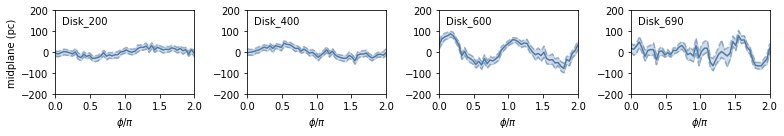

In [7]:
fig, ax = plt.subplots(1, 4, sharex=True, figsize=(11,2))
# now make paper plot, with just fit
for gal,x in zip(glist,ax):
    out = np.load('/home/douglas/Chervin/out_'+gal+'.npy')
    theta = out[:,0]
    result = out[:,1:7]
    fit = out[:,7]

    midplane_est = result[:,0]
    err_low = result[:,1]
    err_high = result[:,2]

    midplane_vel = result[:,3]
    err_vel_low = result[:,4]
    err_vel_high = result[:,5]

    x.set_xlabel('$\phi/\pi$')

    x.text(0.05, 0.88, gal, 
               horizontalalignment='left', 
               verticalalignment='center', 
               transform = x.transAxes)

    x.set_xlim(0, 2)
    x.set_xlim(0, 2)

    x.set_ylim(-200, 200)
    x.set_ylim(-200, 200)

    x.plot(theta/np.pi, (midplane_est-fit)*1000, c=tb_c[0])
    x.plot(theta/np.pi, (err_low-fit)*1000, c=tb_c[0], ls='dashed', alpha=0.5)
    x.plot(theta/np.pi, (err_high-fit)*1000, c=tb_c[0], ls='dashed', alpha=0.5)
    x.fill_between(theta/np.pi, (err_high-fit)*1000, (err_low-fit)*1000, color=tb_c[0], alpha=0.25)

ax[0].set_ylabel('midplane (pc)')

fig.tight_layout()
plt.savefig('/home/douglas/Chervin/midplane_fit.pdf')